#### SARIMA

In [1]:
import pandas as pd
df = pd.read_csv("arrivals.csv")

In [2]:
df.head()

,Date,arrivals
0,1970-01,5158
1,1970-02,5436
2,1970-03,4814
3,1970-04,3284
4,1970-05,3754


In [3]:
df.tail()

,Date,arrivals
663,2025-04,174608
664,2025-05,132919
665,2025-06,138241
666,2025-07,200244
667,2025-08,198235


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      668 non-null    object
 1   arrivals  668 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.6+ KB


In [5]:
df.describe()

,arrivals
count,668.000000
mean,51230.163174
std,56117.724185
min,0.000000
25%,17658.750000
50%,31048.500000
75%,52449.250000
max,253169.000000


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

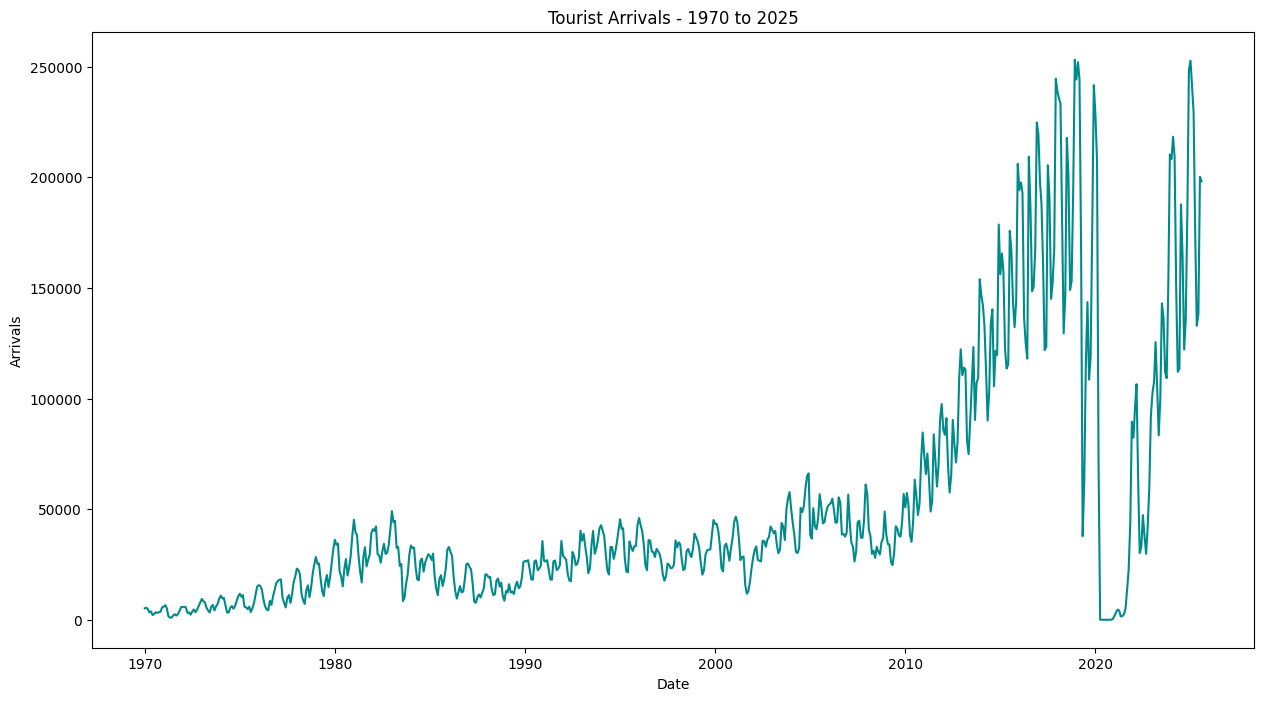

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['arrivals'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Arrivals", title=f"Tourist Arrivals - 1970 to 2025")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

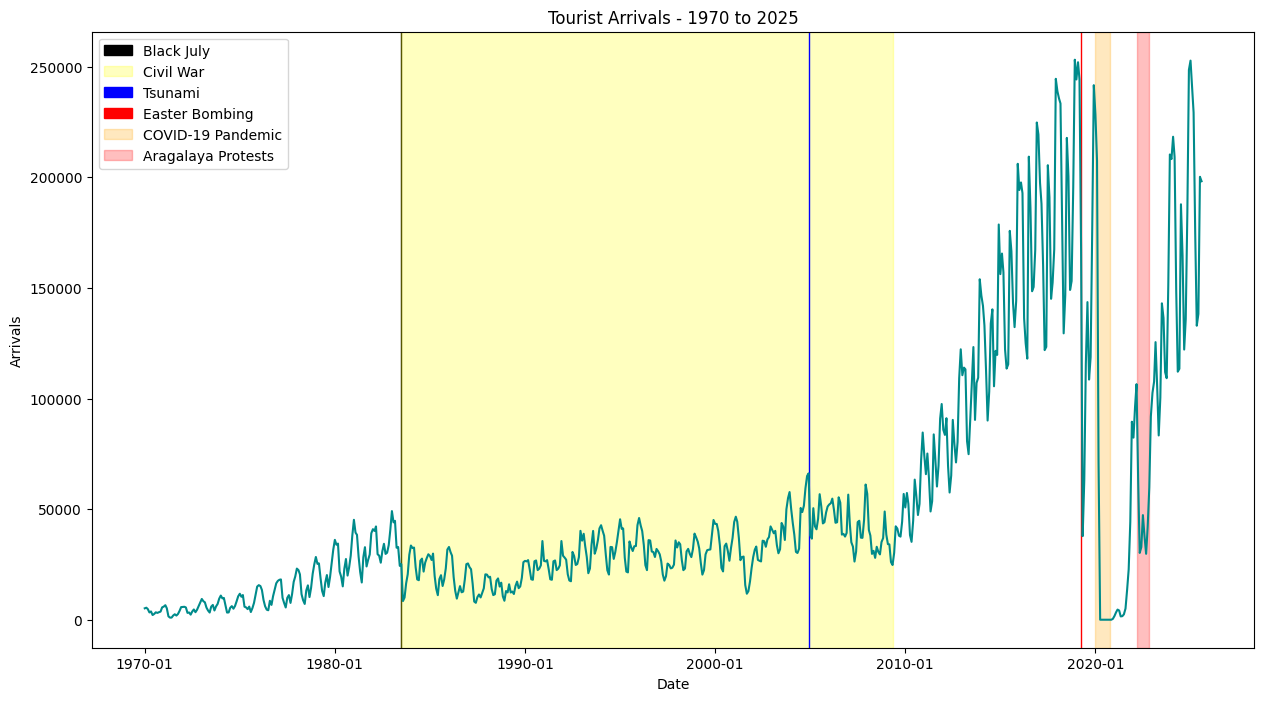

In [8]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['arrivals'], color='#008B8B')

# Black July
ax.axvspan(pd.Timestamp('1983-07-01'), pd.Timestamp('1983-07-01'), color='black', alpha=1, label='Black July')

# Civil War
ax.axvspan(pd.Timestamp('1983-07-01'), pd.Timestamp('2009-05-01'), color='yellow', alpha=0.25, label='Civil War')

# Tsunami
ax.axvspan(pd.Timestamp('2004-12-01'), pd.Timestamp('2004-12-01'), color='blue', alpha=1, label='Tsunami')

# Easter Bombing
ax.axvspan(pd.Timestamp('2019-04-01'), pd.Timestamp('2019-04-01'), color='red', alpha=1, label='Easter Bombing')

# COVID-19 Pandemic
ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-10-01'), color='orange', alpha=0.25, label='COVID-19 Pandemic')

# Aragalaya
ax.axvspan(pd.Timestamp('2022-03-01'), pd.Timestamp('2022-11-01'), color='red', alpha=0.25, label='Aragalaya Protests')

ax.set(xlabel="Date", ylabel="Arrivals", title="Tourist Arrivals - 1970 to 2025")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.legend()
plt.show()

In [9]:
df.set_index('Date', inplace=True)

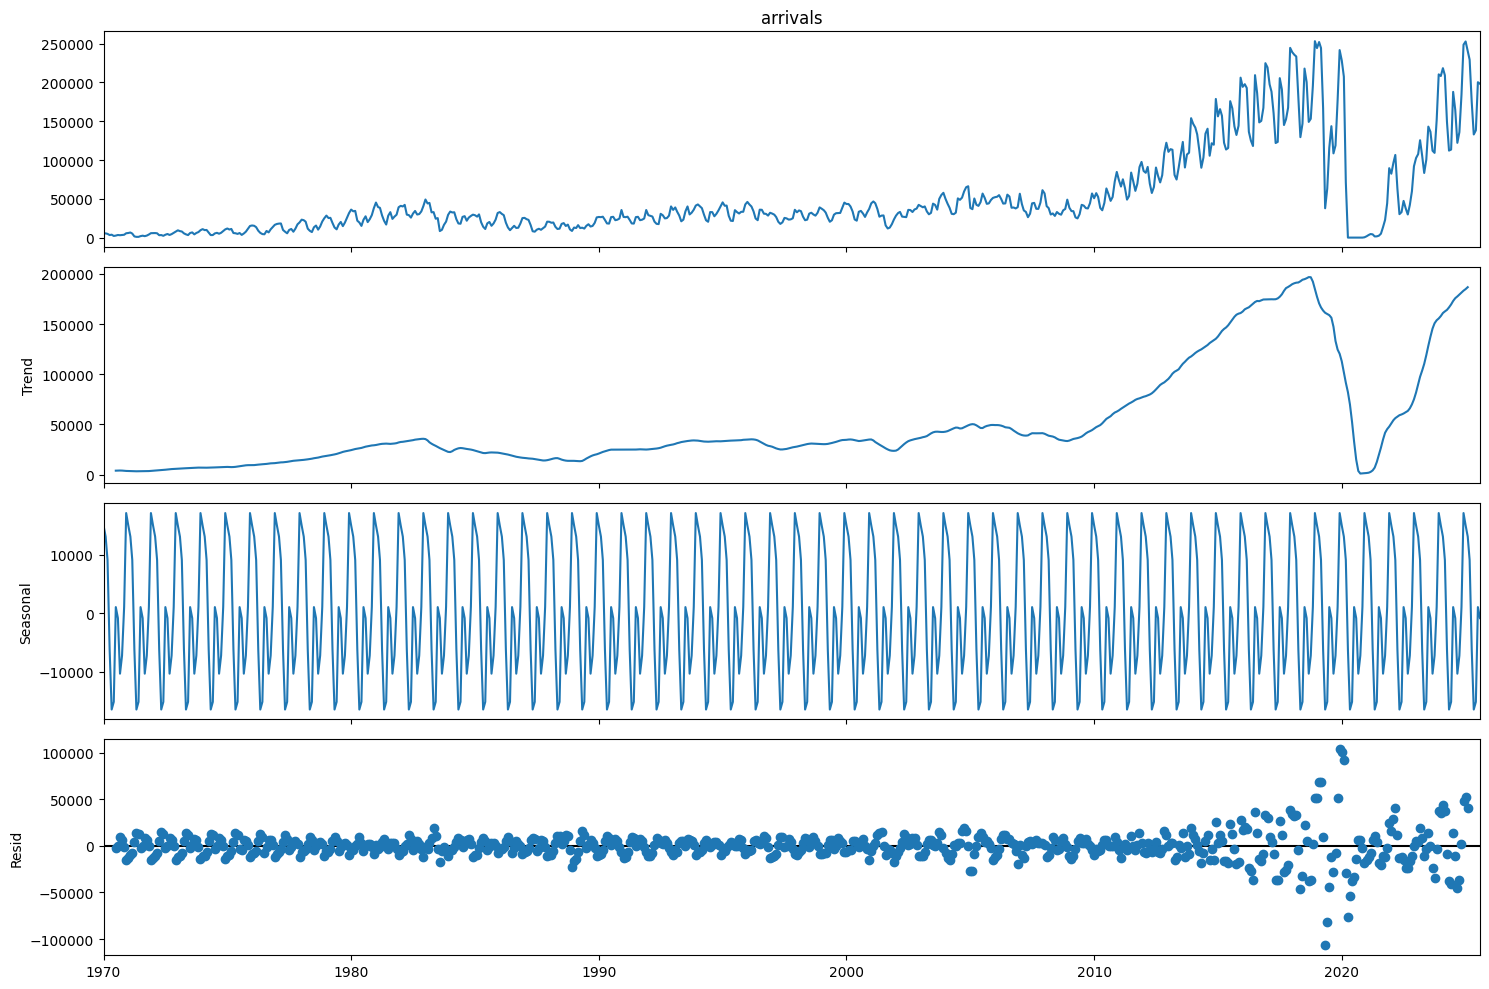

In [10]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['arrivals'], model='additive', period=12)

plt.rcParams["figure.figsize"] = (15, 10)

result.plot()
plt.tight_layout()
plt.show()

In [11]:
seasonal = result.seasonal

df['Month'] = df.index.month

seasonal_df = seasonal.to_frame(name='Seasonal')
seasonal_df['Month'] = df['Month']

seasonal_index = seasonal_df.groupby('Month')['Seasonal'].mean()

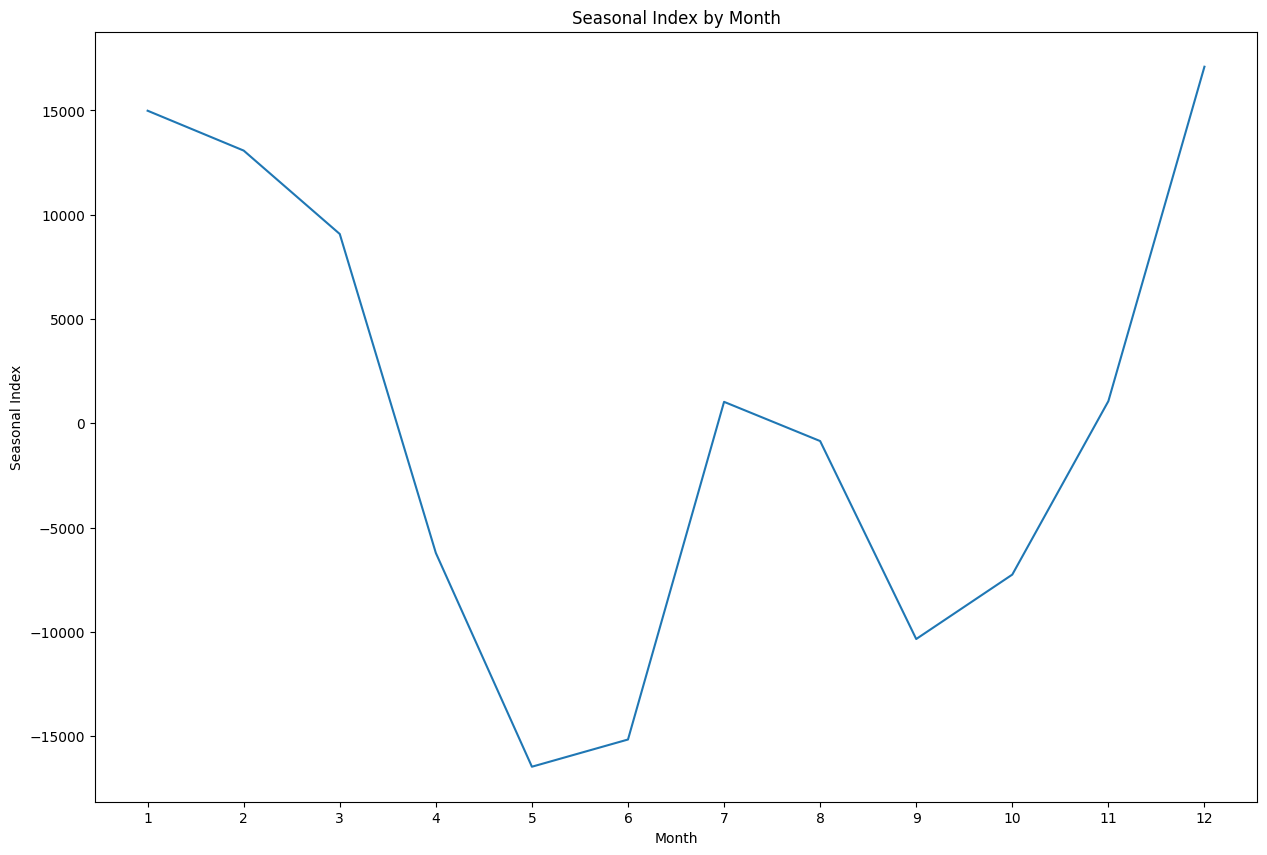

In [12]:
seasonal_index.plot(kind='line', title='Seasonal Index by Month')
plt.ylabel('Seasonal Index')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.show()

#### Trend
Tourist arrivals generally show an upward trend. However, this trend was subdued during the civil war, the COVID-19 pandemic, and the Aragalaya protests.

#### Seasonality
Tourist arrivals are averagely highest in December and January month while it is lowest in May and June months.

In [13]:
df.reset_index(inplace=True)

To test the stationarity of the series, the Augmented Dickey–Fuller (ADF) test was conducted.

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['arrivals'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.878567744380577
p-value: 0.34220970737419387


Since the p-value is greater than 0.05, the series is non-stationary. Therefore, the series was detrended using first-order differencing.

In [15]:
df['diff'] = df['arrivals'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.86746065903963
p-value: 4.03337107137153e-05


Since the p-value is less than 0.05, the series is stationary.

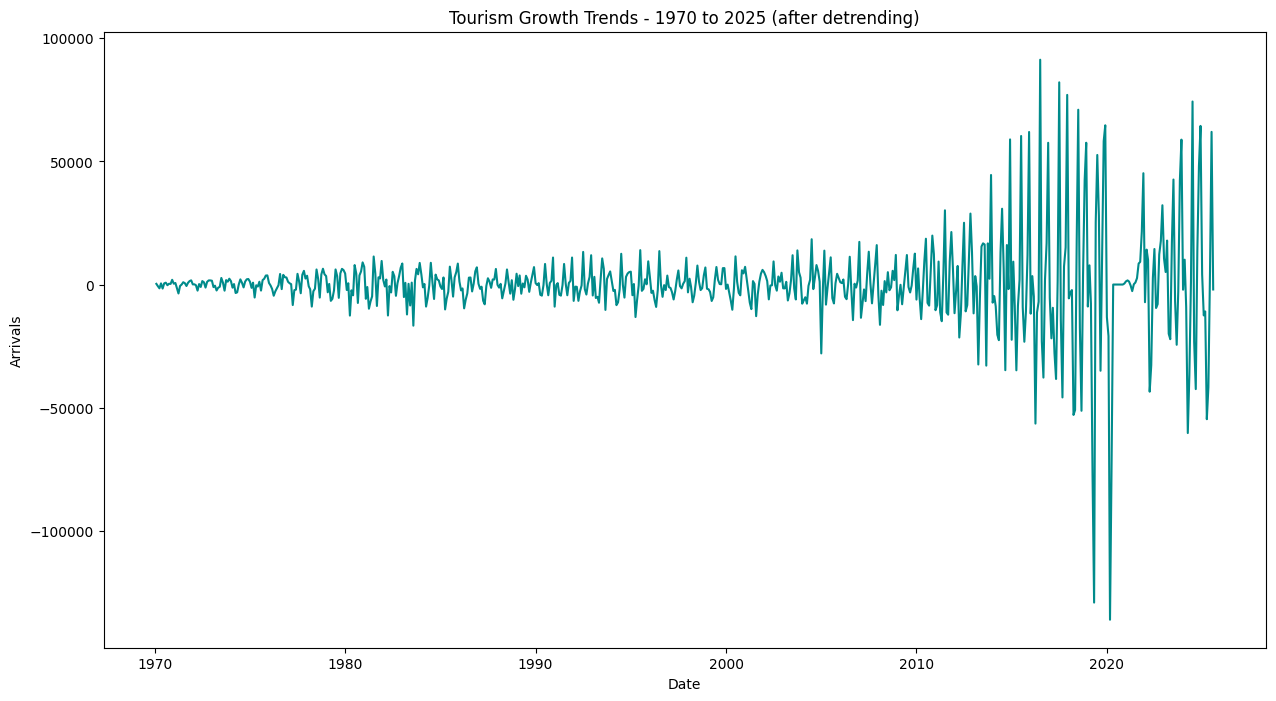

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['diff'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Arrivals", title=f"Tourism Growth Trends - 1970 to 2025 (after detrending)")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

To detect autocorrelation ACF and PACF plots were obtained. ACF and PACF assume stationarity of the underlying time series

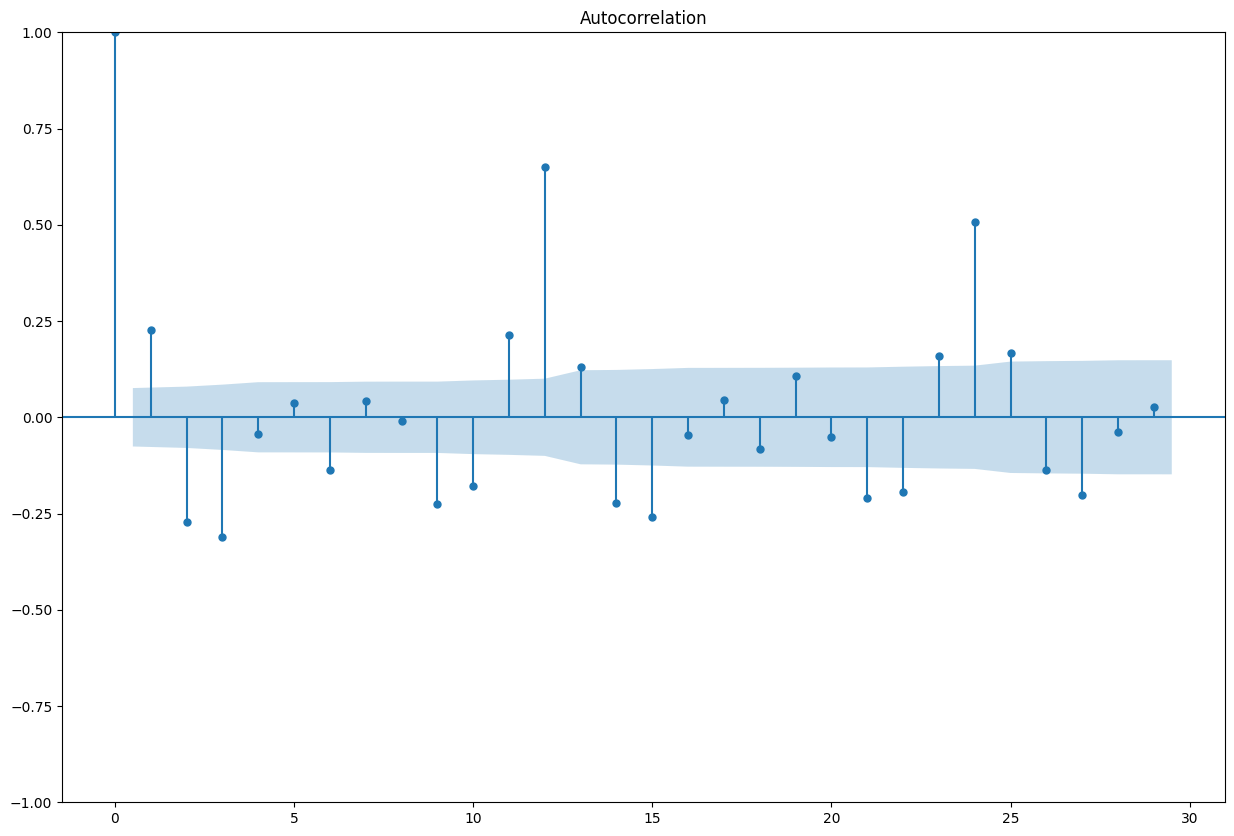

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['diff'])
plt.show()

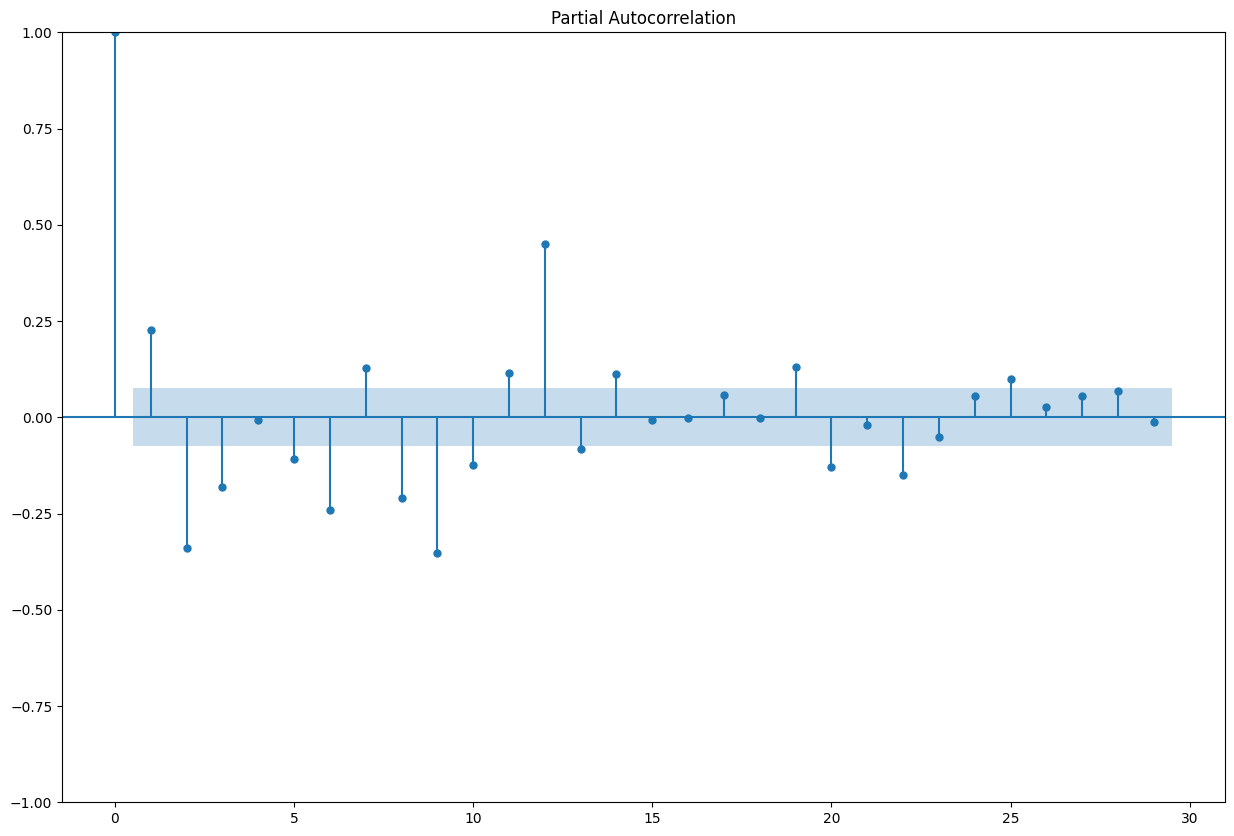

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['diff'])
plt.show()

Both the ACF and PACF show strong correlations at lags 1, 2, and 3. Since the series has already been detrended, an ARMA model is suitable as a starting point, such as ARMA(1,0) or ARMA(0,1). For the original data, an ARIMA(1,1,0) or ARIMA(0,1,1) model would be more appropriate.

After observing the previous plots and the spikes at lags 12 and 24 in the ACF plot, it is clear that deseasonalizing should be performed.

In [19]:
seasonal_period = 12
df['diff_seasonal'] = df['diff'] - df['diff'].shift(seasonal_period)
df.dropna(inplace=True)

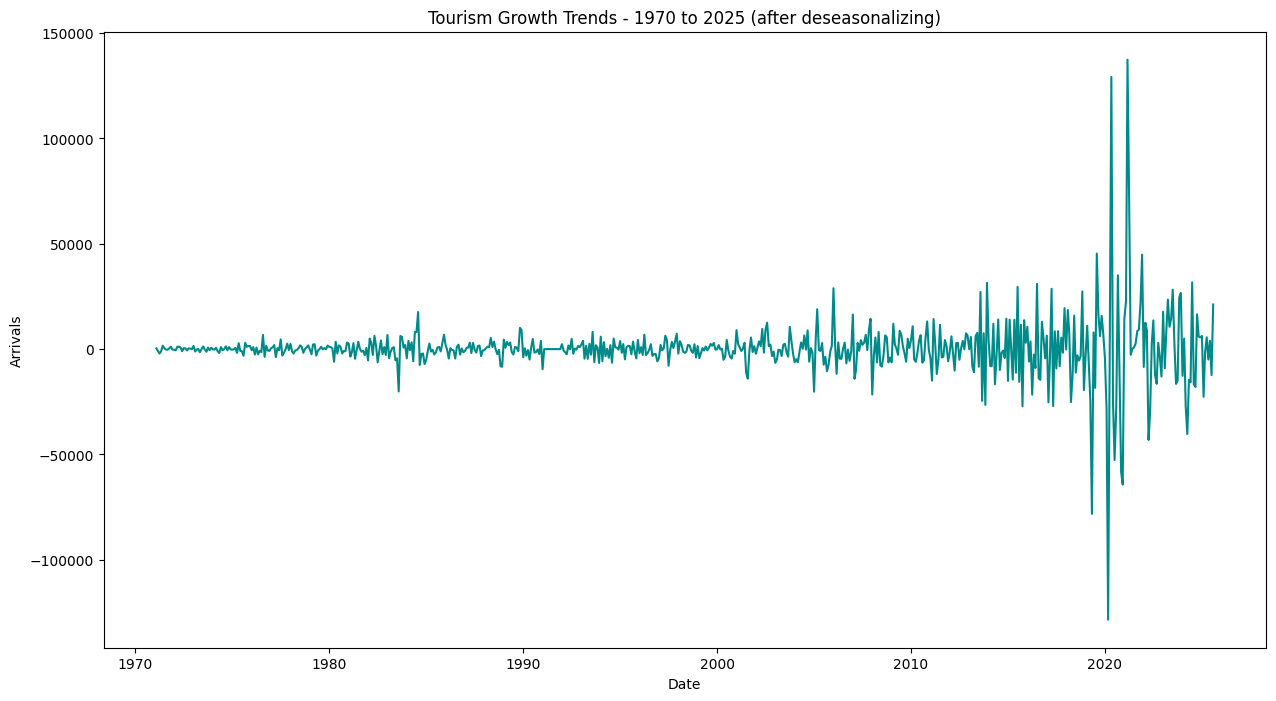

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['diff_seasonal'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Arrivals", title=f"Tourism Growth Trends - 1970 to 2025 (after deseasonalizing)")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

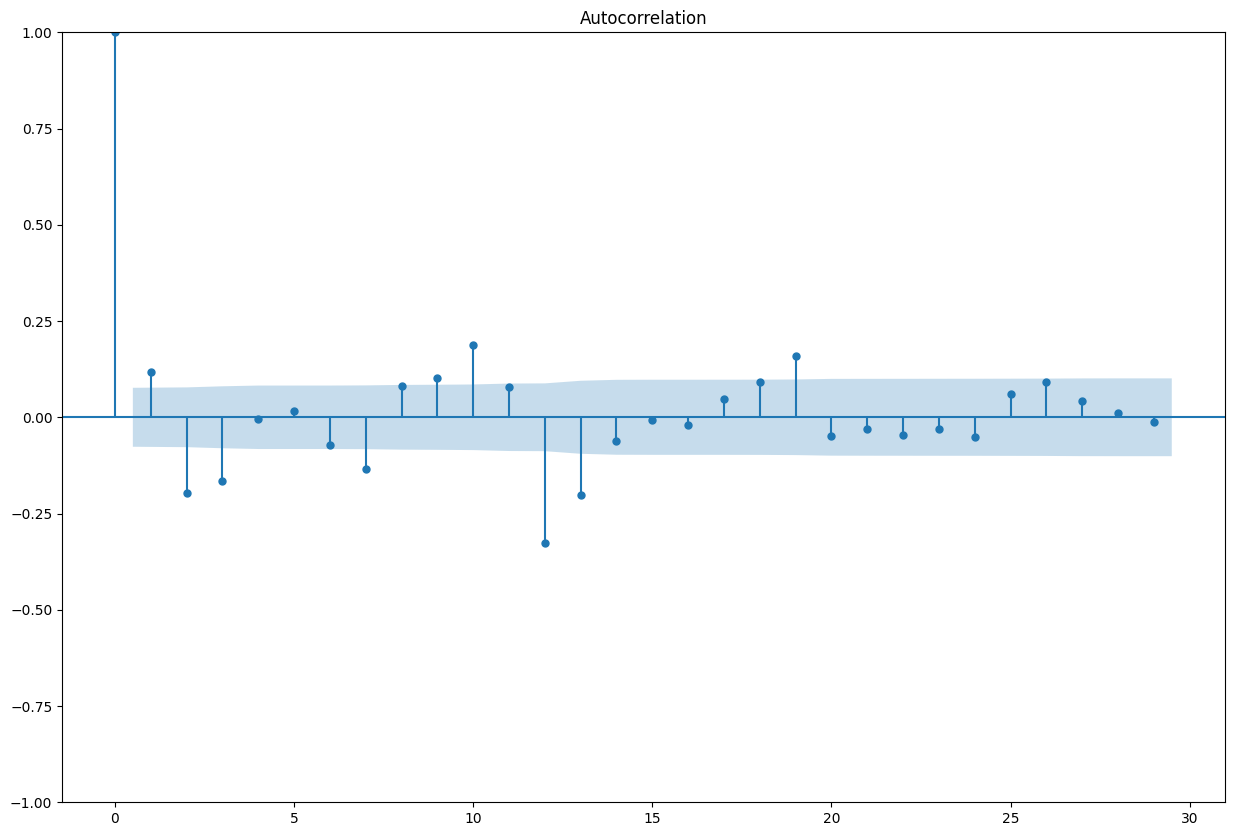

In [21]:
plot_acf(df['diff_seasonal'])
plt.show()

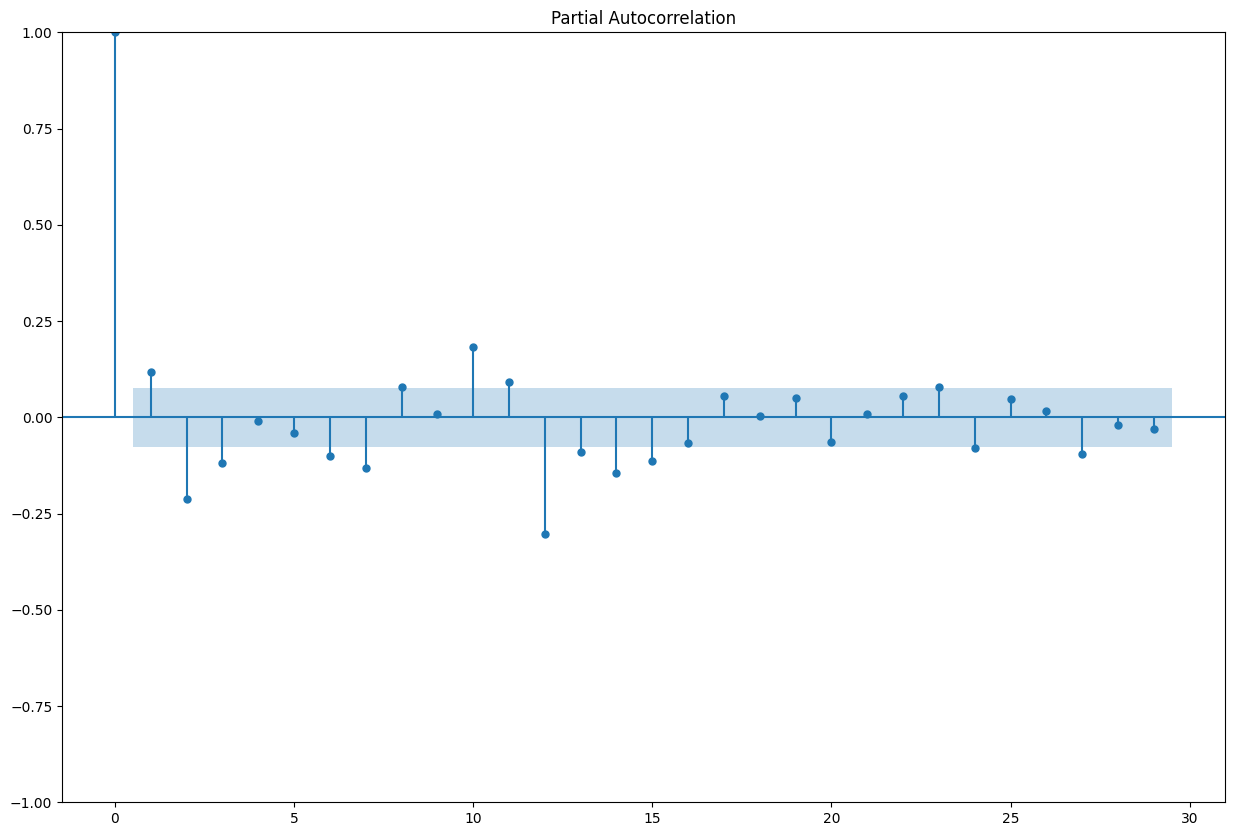

In [22]:
plot_pacf(df['diff_seasonal'])
plt.show()

Both the ACF and PACF show strong correlations at lags 1, 2, and 3. Since the series has already been deseasonalized, a SARIMA model can be used as a starting point for the original data, such as SARIMA(0,1,1)(0,1,1)[12].

In [23]:
df.set_index('Date', inplace=True)

In [24]:
train_size = int(len(df) * 0.8)
train = df['arrivals'].iloc[:-12]
test = df['arrivals'].iloc[-12:]

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
import pmdarima as pm

model = pm.auto_arima(
    train, 
    seasonal=True, 
    m=12,
    stepwise=True,
    trace=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=13980.584, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14337.097, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14053.595, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=14132.656, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14335.232, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=14065.376, Time=0.34 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=13994.411, Time=0.33 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=13970.900, Time=2.63 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=13985.762, Time=1.03 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=13972.573, Time=2.98 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=13972.895, Time=1.82 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=13995.057, Time=1.04 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=13949.884, Time=3.10 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=13974.724, Time=0.45 sec
 ARIM

In [27]:
pred = model.predict(n_periods=len(test))

MAE: 17217.66, MSE: 423583871.98, RMSE: 20581.15


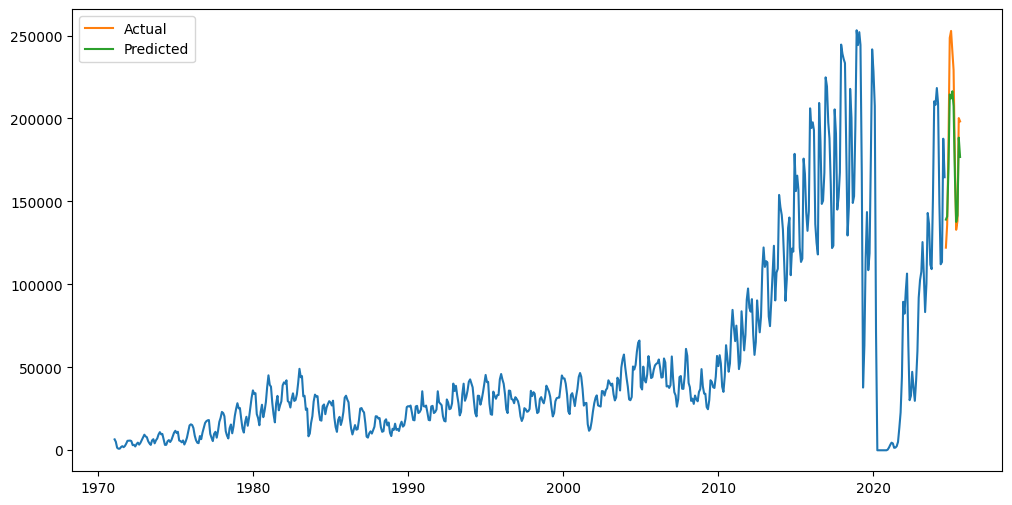

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test, label='Actual')
plt.plot(test.index, pred, label='Predicted')
plt.legend()
plt.show()

#### Random Forest

Detrending is usually necessary if you want a tree-based model like Random Forest to produce forecasts that follow an upward/downward trend or reach higher/lower ranges than seen in the training window.

In [29]:
df = pd.read_csv("arrivals.csv")

In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [31]:
df['diff'] = df['arrivals'].diff()
df.dropna(inplace=True)

In [32]:
df['lag_1'] = df['diff'].shift(1)
df['rolling_mean_12'] = df['diff'].rolling(12).mean()
df = df.dropna()

In [33]:
features = ['lag_1', 'rolling_mean_12']
X = df[features]
y = df['diff']

In [34]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
pred_rf = model.predict(X_test)

In [36]:
last_train_value = df['arrivals'].iloc[train_size - 1]

pred_rfn = []
for d in pred_rf:
    last_train_value = last_train_value + d
    pred_rfn.append(last_train_value)

pred_rfn = np.clip(pred_rfn, 0, None)

MAE: 40342.42, MSE: 2909389903.25, RMSE: 53938.76


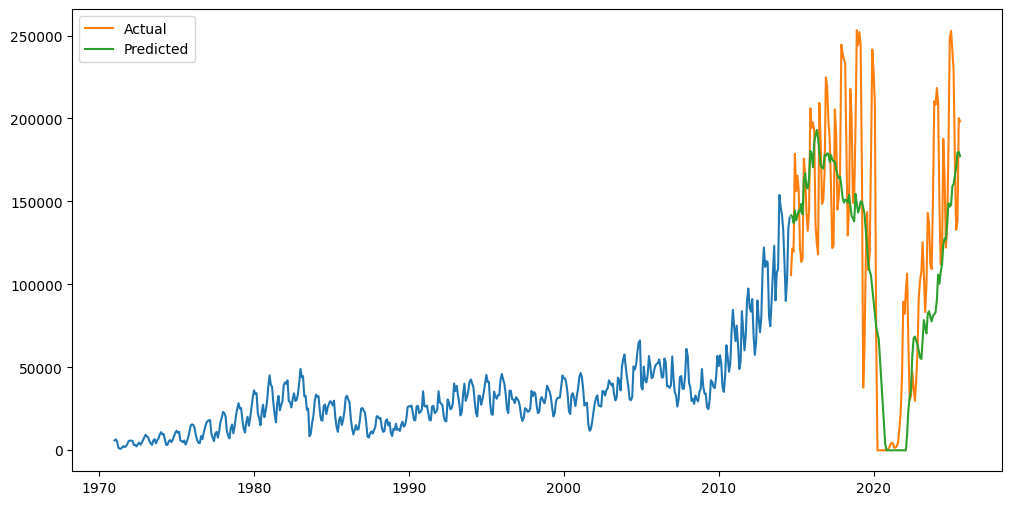

In [37]:
actual_rf = df['arrivals'].iloc[train_size:]

mae = mean_absolute_error(actual_rf, pred_rfn)
mse = mean_squared_error(actual_rf, pred_rfn)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[:train_size], df['arrivals'].iloc[:train_size])
plt.plot(actual_rf.index, actual_rf, label='Actual')
plt.plot(actual_rf.index, pred_rfn, label='Predicted')
plt.legend()
plt.show()

#### LSTM

In [38]:
df = pd.read_csv("arrivals.csv")

In [39]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [40]:
df['lag_1'] = df['arrivals'].shift(1)
df['rolling_mean_12'] = df['arrivals'].rolling(12).mean()
df = df.dropna()

In [41]:
features = ['lag_1', 'rolling_mean_12']
X = df[features]
y = df['arrivals']

In [42]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [43]:
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm = Sequential()
lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_lstm.shape[1], 1)))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1525245952.0000
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1538051200.0000 
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1699383424.0000 
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1614888320.0000 
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1642007808.0000 
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1766447488.0000 
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1585205376.0000 
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1650327040.0000 
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1640587648.0000 
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1621319168.0000 
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1568662400.0000 
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1529551104.0000
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1644659328.0000 
Epoch 14/50
17/17 ━━━━━

In [46]:
pred_lstm = model_lstm.predict(X_test_lstm)

NameError: name 'model_lstm' is not defined

MAE: 26191.89, MSE: 1246859904.00, RMSE: 35310.90


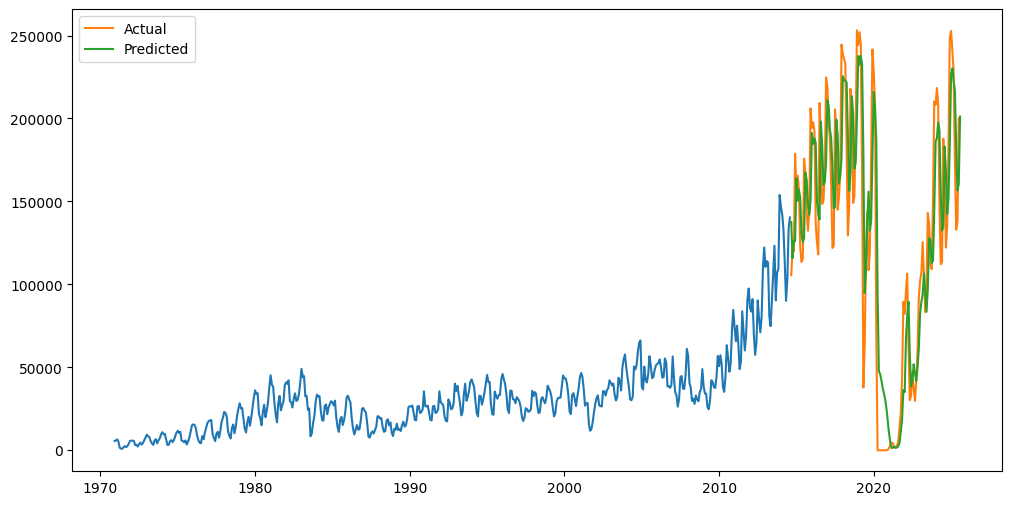

In [ ]:
actual_lstm = df['arrivals'].iloc[train_size:]

mae = mean_absolute_error(actual_lstm, pred_lstm)
mse = mean_squared_error(actual_lstm, pred_lstm)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[:train_size], df['arrivals'].iloc[:train_size])
plt.plot(actual_lstm.index, actual_lstm, label='Actual')
plt.plot(actual_lstm.index, pred_lstm, label='Predicted')
plt.legend()
plt.show()